# Discrete Convolution #

In diesem Notebook geht es um das Thema _Discrete Convolution_ , auf Deutsch _Diskrete Faltung_ , die eine der wichtigsten Rechenoperationen in der digitalen Signalverarbeitung ist

Im Buch *Software Defined Radio for Engineers*, das man [hier](https://www.analog.com/en/education/education-library/software-defined-radio-for-engineers.html) angucken kann, findet man im Kapitel 2.6 einige Erklärungen und ein MATLAB-Skript namens *my_convolution.m, das als Vorbild für den folgenden Python-Code gedient hat.


## Worum geht es bei der diskreten Faltung? ##

Faltung ist eine Rechenoperation, die es auch im Bereich der kontinuierlichen Funktionen gibt.

Die Faltung zweier (auch komplexwertiger) Funktionen $ f \ast g $ ist definiert durch

$ (f \ast g)(x):=\int f(\tau )g(x-\tau ){\mathrm  {d}}\tau $

(siehe https://de.wikipedia.org/wiki/Faltung_(Mathematik))

Was die Faltung anschaulich tut, ist in der Wikipedia bestens beschrieben:
Anschaulich bedeutet die Faltung $ f \ast g $, dass jeder Wert von $ f $ durch das mit $ g $ gewichtete Mittel der ihn umgebenden Werte ersetzt wird. Genauer wird für den Mittelwert $ (f \ast g)(x) $ der Funktionswert $ f(\tau ) $ mit $ g(x-\tau ) $ gewichtet. Die resultierende „Überlagerung“ zwischen $ f $ und gespiegelten und verschobenen Versionen von $ g $ (man spricht auch von einer „Verschmierung“ von $ f $ kann z. B. verwendet werden, um einen gleitenden Durchschnitt zu bilden.

Bei der diskreten Faltung

$ (f*g)(n)=\sum _{{k}}f(k)g(n-k) $

ist es genauso. Die Faltung verknüpft das Eingangssignal $ f $ mit dem Ausgangssignal $ f \ast g$ über die Gewichtung $ g $.
Wenn das Eingangssignal im kontinuierlichen Fall ein Dirac-Puls oder im diskreten Fall ein Einheitsimpuls ist, dann ist das Resultat der Faltungsoperation die Gewichtung $ g $, die auch manchmal _Glättungskern_ oder einfach nur _Kern_ oder _kernel_ genannt wird.

Im folgenden wird angenommen, dass $ f $ und $ g $ nur 1 Dimension besitzen:

Wenn der _Kern_ aus M diskreten Werten besteht, dann muss nach obiger Gleichung der Index $ k $ in der Summe von $ 0 $ bis $ k $ laufen. Für jeden Abtastwert müssen also $ M $ Multiplikationen und $ M $ Additionen durchgeführt werden (diese Operationen werden in der digitalen Signalverarbeitung oft als _MAC_ -Operationen bezeichnet, für _Multiply and Accumulate_.

Wie man aus obiger Gleichung auch erkennen, tragen zu jedem Ausgangs-Abtastwert $ (f*g)(n) $ mit dem Index $ n $ alle Abtastwerte $ f(k) $ bei, bei denen $ g(n-k) $ nicht Null ist.
In jedem Ausgangs-Abtastwert steckt also gewissermaßen die Information von vielen Eingangs-Abtastwerten.

In den folgenden Beispielen wird die diskrete Faltung verwendet, um ein Eingangssignal einer Tiefpassfilterung und einer Hochpassfilterung zu unterziehen:

## Beispiel: Tiefpassfilter ##

Bevor es richtig losgeht, wird zuerst die matplotlib-Bibliothek und die numpy-Bibliothek importiert.
Außerdem wird eine einfache plot-Funktion für die folgenden Diagramme definiert, damit man sich im weiteren Verlauf ein paar Programmzeilen sparen kann:

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def sample_plot(data, x1, x2, titlestr):
    plt.plot(data,'o')
    plt.xlabel('Sample number')
    plt.ylabel('Amplitude')
    plt.xlim(x1, x2)
    plt.grid(b=True)
    plt.title(titlestr)

Als Beispiel-Eingangsdaten, die tiefpassgefiltert werden sollen, werden 3 Sinusschwingungen verwendet (diese Sinusschwingungen repräsentieren eine _hohe_ Frequenz) und einer langsamen Rampenfunktion überlagert.
Die Rampenfunktion besteht vorwiegend aus niederfrequenten Signalanteilen.

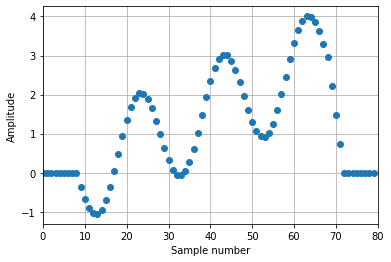

In [38]:
samples1_len = 80
samples1_cnt = np.arange(0, samples1_len) #excluding stop
samples1_sin = 1.3*np.sin(samples1_cnt/samples1_len*2*4*np.pi)
samples1 = np.zeros(samples1_len)
samples1[8:69] = -samples1_sin[0:61] + 3.0/61*samples1_cnt[0:61]
m1 = samples1[68]/(68-72)
b1 = -m1 * 72
samples1[68:72] = m1 * samples1_cnt[68:72] + b1

plt.figure(num=1, figsize=(6, 4))
sample_plot(samples1, 0, samples1_len, '')

Das Tiefpassfilter, also der _kernel_ , besteht in diesem Beispiel aus einem Viertel einer Sinusschwingung 

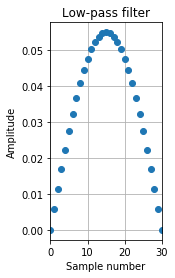

In [39]:
# low-pass filter:
impulse1_len = 30
impulse1_phase = np.arange(0, np.pi*(impulse1_len+1)/impulse1_len,
                           np.pi/impulse1_len)
impulse1 = 0.055*np.sin(impulse1_phase)

plt.figure(num=2, figsize=(2, 4))
sample_plot(impulse1, 0, impulse1_len, 'Low-pass filter')

Die diskrete Faltungsoperation wird durch den folgenden Code-Abschnitt umgesetzt:

In [40]:
# Receive two vectors and return a vector resultant of
# convolution operation
def simple_conv(f,g):
    # Transform the vectors f and g in new vectors with the same length
    F = np.zeros( len(f) + len(g))
    G = np.zeros( len(f) + len(g))
    F[0:len(f)] = f
    G[0:len(g)] = g
    # Create a new vector C
    C = np.zeros(len(g)+len(f)-1)
    # FOR Loop to put the result of convolution between F and G vectors
    # in a new vector C. According to the convolution operation
    # characteristics, the length of a resultant vector of convolution
    # operation between two vector is the sum of vectors length minus 1
    for i in range(0, len(g)+len(f)-1): # range does not include last element
        # FOR Loop to walk through the vector F ang G
        for j in range(0, len(f)):
            if (i-j+1>0):
                C[i] = C[i] + F[j] * G[i-j+1]
    return C

Mit den folgenden Code-Zeilen werden die Eingangsdaten mit dem _kernel_ gefaltet und dargestellt:

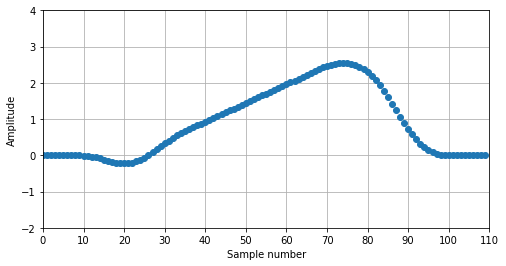

In [41]:
filtered1 = simple_conv(samples1, impulse1)

plt.figure(num=3, figsize=(8, 4))
plt.xticks(np.arange(0, 120, step=10))
plt.grid(b=True, which="minor")
plt.ylim(-2, 4)
sample_plot(filtered1, 0, len(filtered1), '')

Wie man an dem obigen Plot gut sehen kann, ist das Ausgangssignal eine ziemlich glatt verlaufende Kurve.
Die Faltung mit dem Tiefpass-Kern hat die niederfrequenten Anteile der Rampe durchgelassen, aber die schnelleren Sinusschwingungen herausgefiltert.

## Beispiel: Hochpassfilter ##

Der Hochpassfilter-Kern wird durch die folgenden Programmzeilen erzeugt und dargestellt:

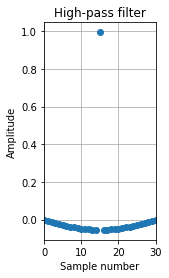

In [42]:
impulse2 = -1 * impulse1
midindx = int(len(impulse2)/2)
impulse2[midindx] = 0
impulse2[midindx] = -np.sum(impulse2)

plt.figure(num=5, figsize=(2, 4))
sample_plot(impulse2, 0, impulse1_len, 'High-pass filter')

Die folgenden Zeilen führen wieder die Faltung und die Darstellung des Ergebnisses durch:

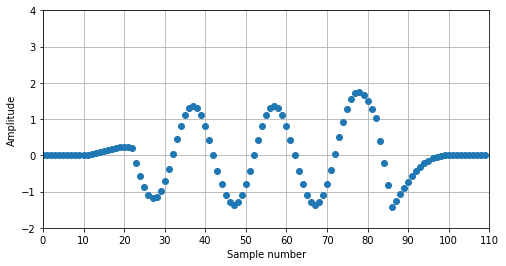

In [43]:
filtered2 = simple_conv(samples1, impulse2)

plt.figure(num=6, figsize=(8, 4))
plt.xticks(np.arange(0, 120, step=10))
plt.ylim(-2, 4)
sample_plot(filtered2, 0, len(filtered2), '')

Wie man oben sehen kann, werden durch die Faltung mit dem Hochpass-Kern nur noch die schnellen Sinusschwingungen durchgelassen.